In [54]:
import pandas as pd
import numpy as np
from gravity_utils import *

In [55]:
pd.set_option('display.max_rows', 1398)

In [56]:
import shapefile
import shapely.wkt

In [57]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn import metrics
import statsmodels.api as sm
from scipy import stats
import stat
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, MinMaxScaler
from sklearn.metrics import r2_score, log_loss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso

In [58]:
def print_stats (model, X, y):
    """Prints coefficients, t-values and probabilities P value?"""
    lm = model
#     params = np.append(lm.intercept_,lm.coef_)
    params = lm.coef_
    predictions = lm.predict(X)

    # newX = pd.DataFrame({"Constant":np.ones(len(X))}, index = X.index).join(pd.DataFrame(X))
#     newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X.reset_index(drop=True)))
    newX = pd.DataFrame(X.reset_index(drop=True))
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

    # Note if you don't want to use a DataFrame replace the two lines above with
    # newX = np.append(np.ones((len(X),1)), X, axis=1)
    # MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilites"] = [params,sd_b,ts_b,p_values]
#     myDF3.index = np.append(['intercept_'], X.columns.values)
    myDF3.index = X.columns.values
    print(myDF3)

In [59]:
sams_w_nbuildings = pd.read_csv('data/GIS/B1_samsSW_20131231_shp/B1_sams_with_nbuildings.csv', sep=';', index_col=0)
sams_w_nbuildings['SAMSCODE'] = sams_w_nbuildings.SAMSCODE.astype(int)
sams_w_nbuildings['KOMMUN'] = sams_w_nbuildings.KOMMUN.astype(int)

In [60]:
resfil_raw = pd.read_csv('data/rvu/RVU_resfil.csv')
upsampled_resfil = draw_population(resfil_raw, resfil_raw.individvikt.astype(int))
upsampled_resfil = upsampled_resfil[(upsampled_resfil['ärende_2'] == 1)] 

# attraction_rvu = upsampled_resfil[(upsampled_resfil['rf4_komkod'] < 2000) &
#                                     (upsampled_resfil['rf4_komkod'] > 100)].groupby('rf4_komkod')['Id'].count()
# production_rvu = upsampled_resfil[(upsampled_resfil['rf1_komkod'] < 2000) &
#                                     (upsampled_resfil['rf1_komkod'] > 100)].groupby('rf1_komkod')['Id'].count()

# production_rvu_sams = upsampled_resfil[(upsampled_resfil['rf1_komkod'] < 2000) &
#                                     (upsampled_resfil['rf1_komkod'] > 100)].groupby('rf1_Samskod')['Id'].count()
# attraction_rvu_sams = upsampled_resfil[(upsampled_resfil['rf4_komkod'] < 2000) &
#                                     (upsampled_resfil['rf4_komkod'] > 100)].groupby('rf4_Samskod')['Id'].count()

In [61]:
resfil_tours_raw = resfil_raw[resfil_raw['ärende_2'] == 1].drop_duplicates(subset=['Id'], keep='first')
upsampled_resfil_tours = draw_population(resfil_tours_raw, resfil_tours_raw.individvikt.astype(int))

attraction_rvu = upsampled_resfil_tours[(upsampled_resfil_tours['rf4_komkod'] < 2000) &
                                    (upsampled_resfil_tours['rf4_komkod'] > 100)].groupby('rf4_komkod')['Id'].count()
production_rvu = upsampled_resfil_tours[(upsampled_resfil_tours['rf1_komkod'] < 2000) &
                                    (upsampled_resfil_tours['rf1_komkod'] > 100)].groupby('rf1_komkod')['Id'].count()

production_rvu_sams = upsampled_resfil_tours[(upsampled_resfil_tours['rf1_komkod'] < 2000) &
                                    (upsampled_resfil_tours['rf1_komkod'] > 100)].groupby('rf1_Samskod')['Id'].count()
attraction_rvu_sams = upsampled_resfil_tours[(upsampled_resfil_tours['rf4_komkod'] < 2000) &
                                    (upsampled_resfil_tours['rf4_komkod'] > 100)].groupby('rf4_Samskod')['Id'].count()

In [62]:
production_raw_rvu = resfil_tours_raw[(resfil_tours_raw['ärende_2'] == 1) &
                                (resfil_tours_raw['rf1_komkod'] < 2000) &
                                (resfil_tours_raw['rf1_komkod'] > 100)].groupby('rf1_Samskod')['Id'].count()
attraction_raw_rvu = resfil_tours_raw[(resfil_tours_raw['ärende_2'] == 1) &
                                (resfil_tours_raw['rf4_komkod'] < 2000) &
                                (resfil_tours_raw['rf4_komkod'] > 100)].groupby('rf4_Samskod')['Id'].count()

In [63]:
rvu_vs_scb = pd.DataFrame([production_raw_rvu, 
                           sams_w_nbuildings.set_index('SAMSCODE').TotBef, 
                           production_raw_rvu / sams_w_nbuildings.set_index('SAMSCODE').TotBef,
                           production_rvu_sams
                          ], 
             index=['rvu', 'sams', 'ratio', 'upsampled_rvu']).T.sort_values(['ratio'], ascending=False)

# sams_ids = rvu_vs_scb[(rvu_vs_scb['ratio'] < 10) & (rvu_vs_scb['ratio'] > 0.03) & (rvu_vs_scb['rvu'] > 5)]
# sams_index = sams_ids.index
sams_index = sams_w_nbuildings.SAMSCODE.values

In [64]:
a2 = read_shapefile('data/GIS/A2_samsSW_2012_shp/A2_sw_region.shp')
a2['KOMMUN'] = a2.KOMMUN.astype(int)
a2['SAMSCODE'] = a2.SAMSCODE.astype(int)
night_pop = a2[(a2.KOMMUN > 1200) & (a2.KOMMUN < 1300)]
# target_night_pop = night_pop.loc[(night_pop.KOMMUN == 1265) | (night_pop.KOMMUN == 1270)]
target_night_pop = night_pop.set_index('SAMSCODE').loc[sams_index].reset_index()
target_night_pop = target_night_pop.groupby(['SAMSCODE'])[['Totalt', 'Offentliga', 'Naringsliv']].sum()
target_night_pop.columns=[u'TotaltA2', u'OffentligaA2', u'NaringslivA2']
# other_night_pop = night_pop.loc[(night_pop.KOMMUN != 1265) & (night_pop.KOMMUN != 1270)]
other_night_pop = night_pop
other_night_pop = other_night_pop.groupby(['KOMMUN'])[['Totalt', 'Offentliga', 'Naringsliv']].sum()
other_night_pop.columns=[u'TotaltA2', u'OffentligaA2', u'NaringslivA2']

a4 = read_shapefile('data/GIS/A4_samsSW_2012_shp/A4_sw_region.shp')
a4['KOMMUN'] = a4.KOMMUN.astype(int)
a4['SAMSCODE'] = a4.SAMSCODE.astype(int)
a4 = a4[(a4.KOMMUN > 1200) & (a4.KOMMUN < 1300)]
target_day_pop = a4.set_index('SAMSCODE').loc[sams_index].reset_index()
# target_day_pop = a4.loc[(a4.KOMMUN == 1265) | (a4.KOMMUN == 1270)]
target_day_pop = target_day_pop.groupby(['SAMSCODE'])[['Totalt', 'Offentliga', 'Naringsliv']].sum()
target_day_pop.columns=[u'TotaltA4', u'OffentligaA4', u'NaringslivA4']
other_day_pop = a4
# other_day_pop = a4.loc[(a4.KOMMUN != 1265) & (a4.KOMMUN != 1270)]
other_day_pop = other_day_pop.groupby(['KOMMUN'])[['Totalt', 'Offentliga', 'Naringsliv']].sum()
other_day_pop.columns=[u'TotaltA4', u'OffentligaA4', u'NaringslivA4']

# target_buildings = sams_w_nbuildings.loc[(sams_w_nbuildings.KOMMUN == 1265) | (sams_w_nbuildings.KOMMUN == 1270)]
target_buildings = sams_w_nbuildings.set_index('SAMSCODE').loc[sams_index].reset_index()
target_buildings = target_buildings.groupby(['SAMSCODE']).sum()
# other_buildings = sams_w_nbuildings.loc[(sams_w_nbuildings.KOMMUN != 1265) & (sams_w_nbuildings.KOMMUN != 1270)]
other_buildings = sams_w_nbuildings
other_buildings = other_buildings.groupby(['KOMMUN']).sum()

#buildings = sams_w_nbuildings.groupby(['SAMSCODE'])['nProduction', 'nAttraction','TotBef', 'small_building', 'appt_build', 'multi_appartment_building'].sum()

In [65]:
production_sams_rvu = upsampled_resfil[(upsampled_resfil['ärende_2'] == 1) &
                                    (upsampled_resfil['rf1_komkod'] < 2000) &
                                    (upsampled_resfil['rf1_komkod'] > 100)].groupby('rf1_Samskod')['Id'].count()
production_kommun_rvu = upsampled_resfil[(upsampled_resfil['ärende_2'] == 1) &
                                    (upsampled_resfil['rf1_komkod'] < 2000) &
                                    (upsampled_resfil['rf1_komkod'] > 100)].groupby('rf1_komkod')['Id'].count()

In [66]:
target_x_sams = pd.concat([target_night_pop, target_buildings, target_day_pop], axis=1).sort_index()
other_x_sams = pd.concat([other_night_pop, other_buildings, other_day_pop], axis=1).sort_index()

all_x_sams = pd.concat([target_x_sams, other_x_sams]).sort_index()

# all_y_prod = pd.concat([target_night_pop, other_night_pop])
# all_y_att = pd.concat([target_day_pop, other_day_pop])

kommun_rvu_prod = production_kommun_rvu.sort_index()
sams_rvu_prod = production_sams_rvu.loc[sams_index].sort_index()

all_y_prod = pd.concat([kommun_rvu_prod, sams_rvu_prod]).sort_index()

/home/ai6644/anaconda3/envs/jup/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.
/home/ai6644/anaconda3/envs/jup/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  # Remove the CWD from sys.path while we load stuff.


In [67]:
other_trip_scb_2018 = pd.read_csv('data/coomuting_municipalities_2018.csv', sep=';', header=[0], index_col=[0])
other_trip_scb_2018['production'] = other_trip_scb_2018['Outgoing commuters'] + other_trip_scb_2018['Work and live in county/municipality']
other_trip_scb_2018['attraction'] = other_trip_scb_2018['Incomming commuters'] + other_trip_scb_2018['Work and live in county/municipality']
other_trip_scb_2003 = pd.read_csv('data/coomuting_municipalities_2013.csv', sep=';', header=[0], index_col=[0])
other_trip_scb_2003['production'] = other_trip_scb_2003['Comuters leaving the municipality'] + other_trip_scb_2003['Working and living in the municipality']
other_trip_scb_2003['attraction'] = other_trip_scb_2003['Comuters coming into the municipality'] + other_trip_scb_2003['Working and living in the municipality']

In [68]:
other_trip_scb_2003 = other_trip_scb_2003.dropna()
other_trip_scb_2018 = other_trip_scb_2018.dropna()

In [69]:
other_trip_scb_raw = \
pd.concat([other_trip_scb_2018.production - (other_trip_scb_2018.production - other_trip_scb_2003.production)*5/15,
           other_trip_scb_2018.attraction - (other_trip_scb_2018.attraction - other_trip_scb_2003.attraction)*5/15,
           other_trip_scb_2018['Outgoing commuters'] - (other_trip_scb_2018['Outgoing commuters'] - other_trip_scb_2003['Comuters leaving the municipality'])*5/15,
           other_trip_scb_2018['Incomming commuters'] - (other_trip_scb_2018['Incomming commuters'] - other_trip_scb_2003['Comuters coming into the municipality'])*5/15,
           other_trip_scb_2018['Work and live in county/municipality'] - (other_trip_scb_2018['Work and live in county/municipality'] - other_trip_scb_2003['Working and living in the municipality'])*5/15,
          ],
         axis=1)
other_trip_scb_raw.columns=['production', 'attraction', 'outgoing', 'incomming', 'within']

In [70]:
other_trip_scb_raw

,production,attraction,outgoing,incomming,within
County/Municipality,,,,,
1214,6420.666667,3998.666667,4008.333333,1586.333333,2412.333333
1230,11115.000000,6318.333333,8450.666667,3654.000000,2664.333333
1231,7476.333333,8257.000000,5501.000000,6281.666667,1975.333333
1233,16125.333333,8499.000000,11189.666667,3563.333333,4935.666667
1256,6280.333333,4848.666667,2911.333333,1479.666667,3369.000000
1257,4457.000000,3883.000000,1910.333333,1336.333333,2546.666667
1260,6609.333333,4803.666667,4040.666667,2235.000000,2568.666667
1261,14433.333333,7940.000000,9982.666667,3489.333333,4450.666667
1262,10470.000000,5527.000000,8099.000000,3156.000000,2371.000000


In [71]:
avg_day_c = production_kommun_rvu.sum() / other_trip_scb_raw.production.sum()
avg_day_c
other_trip_scb = other_trip_scb_raw*avg_day_c

In [72]:
avg_day_c

0.651633045730121

# Production linear regression

In [73]:
lin = Lasso(alpha=0.001,precompute=True,max_iter=10000, fit_intercept=False,
            positive=True, random_state=42, selection='random')

# lin = LinearRegression(fit_intercept=False, )

x_prod = other_x_sams.drop(axis=1, labels=['OffentligaA4','Ald25_44','TotBef', 'appt_build','multi_appartment_building','small_building','Ald65_W','Ald45_64','TotaltA2','Ald20_24','nIndustri','nEkonomi','TotaltA4','Ald16_19','Ald7_15','Ald0_6','nProduction','nAttraction','SAMSCODE'])
y_prod = other_trip_scb.production

# x_prod = other_x_sams.drop(axis=1, labels=['Ald20_24','TotBef','Ald65_W','Ald7_15','multi_appartment_building','nEkonomi','nIndustri','nProduction','appt_build','nAttraction','Ald16_19','Ald0_6','SAMSCODE', 'TotaltA2', 'OffentligaA2', 'NaringslivA2', 'TotaltA4', 'OffentligaA4', 'NaringslivA4'])
# y_prod = other_night_pop.TotaltA2

# x_prod = x_prod.drop(labels=[1280,1281,1283,1290,1292, 1293])
# y_prod = y_prod.drop(labels=[1280,1281,1283,1290,1292, 1293])

scaler_prod = StandardScaler(with_std=False, with_mean=False)
# scaler_att = Normalizer()
# scaler_att = MinMaxScaler()
scaler_prod.fit(x_prod)

X_prod = pd.DataFrame(scaler_prod.transform(x_prod), columns=x_prod.columns, index=x_prod.index)
production_model = lin.fit(X_prod, y_prod)
train_prod_pred = production_model.predict(X_prod)
score = r2_score(y_prod, train_prod_pred)
print('R**2 value')
print(score)
# print(pd.DataFrame(production_model.coef_, index=X_prod.columns))
print_stats(production_model, X_prod, y_prod)

R**2 value
0.9998860706634678
              Coefficients  Standard Errors  t values  Probabilites
OffentligaA2        0.5158            0.018    28.324           0.0
NaringslivA2        0.6993            0.010    68.610           0.0
NaringslivA4        0.0372            0.008     4.939           0.0


In [74]:
pred_prod_sams = pd.DataFrame(
    production_model.predict(scaler_prod.transform(target_x_sams.loc[:, X_prod.columns])), 
    index=target_x_sams.index,
    columns=['trips']
)

In [75]:
pred_prod_sams.describe()

,trips
count,1397.000000
mean,271.495619
std,291.146924
min,0.000000
25%,66.158824
50%,184.282246
75%,371.860304
max,2377.125475


In [76]:
kommun_to_sams = sams_w_nbuildings.groupby(['KOMMUN'])['SAMSCODE'].unique()
predicted_kommun_trips_from_sams = \
    pd.DataFrame([pred_prod_sams.loc[samses].sum().values for _, samses in kommun_to_sams.iteritems()], 
                 index=kommun_to_sams.index, columns=['trips_sams'])
predicted_kommun_trips_from_sams = predicted_kommun_trips_from_sams.join(other_trip_scb.production)

In [77]:
r2_score(predicted_kommun_trips_from_sams.trips_sams, predicted_kommun_trips_from_sams.production)

0.9998854928896254

In [78]:
(predicted_kommun_trips_from_sams.trips_sams / predicted_kommun_trips_from_sams.production).describe()

count    33.000000
mean      1.012254
std       0.020275
min       0.986399
25%       0.997900
50%       1.008151
75%       1.021808
max       1.056983
dtype: float64

In [83]:
(predicted_kommun_trips_from_sams.trips_sams - predicted_kommun_trips_from_sams.production).describe()

count     33.000000
mean      70.799367
std      155.213633
min     -315.933138
25%       -8.910132
50%       44.026163
75%      201.529080
max      359.759500
dtype: float64

# Attraction Linear regression

In [84]:
from sklearn.linear_model import Lasso
lin = Lasso(alpha=0.001,precompute=True,max_iter=10000, fit_intercept=False,
            positive=True, random_state=42, selection='random')

x_att = other_x_sams.drop(axis=1, labels=['TotBef', 'SAMSCODE', 'Ald0_6', 'nProduction', 'nAttraction', 'multi_appartment_building', 'small_building', 'TotaltA2', 'OffentligaA2', 'NaringslivA2', 'Ald7_15', 'Ald16_19', 'Ald20_24','appt_build', 'Ald65_W', 'Ald45_64','TotaltA4', 'nEkonomi'])
y_att = other_trip_scb.attraction

# x_att = x_att.drop(labels=[1280,1281,1283,1290,1292, 1293])
# y_att = y_att.drop(labels=[1280,1281,1283,1290,1292, 1293])

# x_att_s = x_att.append(pd.DataFrame(np.zeros(len(x_att.columns)), index=x_att.columns).T)
scaler_att = StandardScaler(with_std=False, with_mean=False)
# scaler_att = Normalizer()
# scaler_att = MinMaxScaler()
scaler_att.fit(x_att)

X_att = pd.DataFrame(scaler_att.transform(x_att), columns=x_att.columns, index=x_att.index)
attraction_model = lin.fit(X_att, y_att)
train_att_pred = attraction_model.predict(X_att)
score = r2_score(y_att, train_att_pred)
print('R**2 value')
print(score)
print_stats(attraction_model, X_att, y_att)

R**2 value
0.9997709289511443
              Coefficients  Standard Errors  t values  Probabilites
Ald25_44            0.2051            0.029     7.003           0.0
nIndustri           0.9510            0.197     4.833           0.0
OffentligaA4        0.6471            0.025    25.617           0.0
NaringslivA4        0.5360            0.026    20.234           0.0


In [85]:
pred_att_sams = pd.DataFrame(
    attraction_model.predict(scaler_att.transform(target_x_sams.loc[:, X_att.columns])), 
    index=target_x_sams.index,
    columns=['trips']
)
pred_att_sams.describe()

,trips
count,1397.000000
mean,267.022473
std,454.666141
min,0.000000
25%,52.485378
50%,133.370841
75%,310.093441
max,5985.384590


In [86]:
kommun_to_sams = sams_w_nbuildings.groupby(['KOMMUN'])['SAMSCODE'].unique()
predicted_kommun_trips_from_sams = \
    pd.DataFrame([pred_att_sams.loc[samses].sum().values for _, samses in kommun_to_sams.iteritems()], 
                 index=kommun_to_sams.index, columns=['trips_sams'])
predicted_kommun_trips_from_sams = predicted_kommun_trips_from_sams.join(other_trip_scb.attraction)

In [87]:
r2_score(predicted_kommun_trips_from_sams.trips_sams, predicted_kommun_trips_from_sams.attraction)

0.9997693393236631

In [88]:
(predicted_kommun_trips_from_sams.trips_sams / predicted_kommun_trips_from_sams.attraction).describe()

count    33.000000
mean      1.028054
std       0.052064
min       0.906502
25%       0.986583
50%       1.033069
75%       1.064003
max       1.153474
dtype: float64

In [90]:
(predicted_kommun_trips_from_sams.trips_sams - predicted_kommun_trips_from_sams.attraction).describe()

count     33.000000
mean      94.033114
std      293.186079
min     -631.077677
25%     -100.621414
50%      106.386649
75%      249.627559
max      725.829073
dtype: float64

# Gravity model for SAMS

# Gravity

In [31]:
sams_distance_matrix = pd.read_csv('data/sams_distance_matrix.csv', sep=';', index_col=[0])
sams_distance_matrix.columns = sams_distance_matrix.index
#the thing above is differently sorted
sams_distance_matrix = sams_distance_matrix.sort_index().T.sort_index().T

In [32]:
sams_distance_matrix.replace(0, np.nan, inplace=True)    
for (idx, value) in sams_distance_matrix.min().iteritems():
    sams_distance_matrix.at[int(idx), idx] = value * (2.0 / 3)
# for (idx, value) in sams_distance_matrix.loc[12700000:12709999, 12700000:12709999].min().iteritems():
#     sams_distance_matrix.at[int(idx), idx] = value * (2.0 / 3)
sams_distance_matrix.at[12650001, 12650002] = sams_distance_matrix.loc[12650001].min() * (2.0 / 3)
sams_distance_matrix.at[12650002, 12650001] = sams_distance_matrix.loc[12650002].min() * (2.0 / 3)
sams_distance_matrix.at[12700020, 12700001] = sams_distance_matrix.loc[12700020].min() * (2.0 / 3)
sams_distance_matrix.at[12700001, 12700020] = sams_distance_matrix.loc[12700001].min() * (2.0 / 3)

In [33]:
sams_distance_matrix = sams_distance_matrix.replace(to_replace=np.NAN, value=5000)

(array([4.80557337e-06, 9.89970957e-06, 1.01925869e-05, 8.71474933e-06,
        7.26076835e-06, 6.73338617e-06, 5.97048395e-06, 5.09540516e-06,
        5.37127832e-06, 6.56562890e-06, 7.36355458e-06, 8.01681815e-06,
        7.66226912e-06, 7.40466907e-06, 8.00235194e-06, 8.28583890e-06,
        8.03458368e-06, 7.57547186e-06, 7.71581947e-06, 8.13330921e-06,
        8.21655337e-06, 8.89189695e-06, 9.18883494e-06, 8.61450103e-06,
        8.18787474e-06, 8.10310783e-06, 8.23761820e-06, 8.83098659e-06,
        9.09518527e-06, 8.50841549e-06, 7.74272155e-06, 7.08692004e-06,
        7.05697245e-06, 7.25391593e-06, 7.37497527e-06, 7.21533937e-06,
        7.22802903e-06, 7.84652295e-06, 8.57592447e-06, 8.56957964e-06,
        8.43786100e-06, 8.22036026e-06, 7.90844848e-06, 7.87748571e-06,
        8.07848989e-06, 9.12310251e-06, 1.01364986e-05, 1.07298670e-05,
        1.04479028e-05, 1.02362393e-05, 8.88631350e-06, 7.99448436e-06,
        7.34934216e-06, 6.68313513e-06, 6.49634337e-06, 6.145347

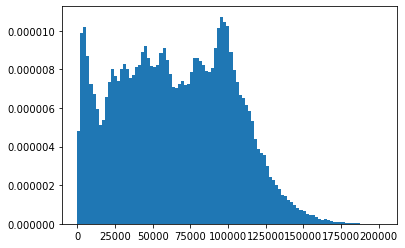

In [34]:
fig, ax = plt.subplots()
ax.hist(sams_distance_matrix.values.flatten(), 100, density=1)
# np.histogram(sams_distance_matrix, bins=100)

In [35]:
pd.Series(np.diag(sams_distance_matrix), index=[sams_distance_matrix.index])

SAMSCODE
12140001    1755.800000
12140002    1886.133333
12140003    1181.933333
12140004    1162.933333
12140005    4779.000000
12140006    4605.266667
12140007     941.000000
12140008    2563.733333
12140009    2921.666667
12140010    1903.266667
12140011    2427.266667
12140012    2427.266667
12140013    2473.533333
12140014    1337.133333
12140015    1338.666667
12140016    2226.133333
12140017    3551.600000
12300003     821.933333
12300004    1606.733333
12300005    1415.000000
12300006    2263.600000
12300007    4087.400000
12300008    2124.666667
12300009    2189.400000
12300010     959.333333
12300011     925.600000
12300012     958.000000
12310002     735.333333
12310003    1262.333333
12310004     638.800000
12310005    1225.133333
12310006     421.266667
12310007     421.266667
12310008    1191.333333
12330001    1439.066667
12330002     468.733333
12330003     468.733333
12330004    1735.733333
12330005    1987.333333
12330006    1637.400000
12330007     906.466667
1233000

In [36]:
# pred_prod_sams = pd.DataFrame(production_model.predict(scaler_prod.transform(all_x_sams.loc[:, x_prod.columns])), index=all_x_sams.index, columns=['predicted_production']).sort_index()
# pred_attr_sams = pd.DataFrame(attraction_model.predict(scaler_att.transform(all_x_sams.loc[:, x_att.columns])), index=all_x_sams.index, columns=['predicted_attraction']).sort_index()

# pred_attr_sams_b = pred_attr_sams * (pred_prod_sams.sum().values / pred_attr_sams.sum().values)

In [37]:
pred_prod_sams = pd.concat([all_x_sams.loc[1299:]]).sort_index()
pred_prod_sams = pd.DataFrame(production_model.predict(scaler_prod.transform(pred_prod_sams.loc[:, x_prod.columns])), index=pred_prod_sams.index, columns=['predicted_production']).sort_index()
pred_attr_sams = pd.concat([all_x_sams.loc[1299:]]).sort_index()
pred_attr_sams = pd.DataFrame(attraction_model.predict(scaler_att.transform(pred_attr_sams.loc[:, x_att.columns])), index=pred_attr_sams.index, columns=['predicted_attraction']).sort_index()


### Mean trip length from RVU

In [38]:
rvu_mtl = upsampled_resfil_tours['rf7_km'].mean() * 1000
print(rvu_mtl)

20698.241043536986


In [39]:
# f = sams_distance_matrix.values
# cost_matrix = np.exp(-6.210386390939112e-05*(f))
# Trips1 = fratar_double_constrained(prodA = pred_prod_sams.values.flatten(),
#                                    attrA = pred_attr_sams.values.flatten(), 
#                                    cost_matrix = cost_matrix,
#                                     num_iter=100)

In [40]:
prodA = pred_prod_sams.values.flatten()
attrA = pred_attr_sams.values.flatten()
f = sams_distance_matrix.values
num_iter=50
num_iter_cal = 100
num_zones = len(prodA)
f = f
alpha = 0.2

# bins = [0., 5000,10000, 20000, 40000, 80000,1000000]
bins = [0., 7000, 10000,25000, 50000, 1000000]
binned_distances = np.digitize(f.flatten(), bins).reshape(len(f),len(f))
observed_tld, _ = np.histogram(upsampled_resfil_tours.rf7_km * 1000, bins)
cost_matrix = np.ones([len(f), len(f)])

trips = np.zeros((num_zones, num_zones))
print('Checking production, attraction balancing:')
sumP = sum(prodA)
sumA = sum(attrA)
print('Production: ', sumP)
print('Attraction: ', sumA)
if sumP != sumA:
    print('Productions and attractions do not balance, attractions will be scaled to productions!')
    attrA = attrA * (sumP / sumA)
    attrT = attrA.copy()
    prodT = prodA.copy()
else:
    print('Production, attraction balancing OK.')
    attrT = attrA.copy()
    prodT = prodA.copy()

trips = cost_matrix * f
#Run 2D balancing --->
computed_attractions = trips.sum(0)
computed_attractions[computed_attractions==0]=1
trips = trips * (attrT / computed_attractions)
trips = trips.round(0)

computed_productions = trips.sum(1)
computed_productions[computed_productions==0]=1
trips = trips * np.reshape((prodT / computed_productions),[len(prodT),1])
trips = trips.round(0)

for Iter in range(0, num_iter_cal):

    computed_attractions = trips.sum(0)
    computed_attractions[computed_attractions==0]=1
    trips = trips * (attrT / computed_attractions)
#     trips = trips.round(0)

    computed_productions = trips.sum(1)
    computed_productions[computed_productions==0]=1
    trips = trips * np.reshape((prodT / computed_productions),[len(prodT),1])
#     trips = trips.round(0)

    modelled_tld = np.array([sum(trips[binned_distances == i]) for i in range(1, len(bins))])
    coeff = modelled_tld/observed_tld
    
    cn = []
    for c in coeff:
        if c > 1:
            cn.append(1+c*alpha)
        elif c < 1:
            cn.append(1-c*alpha)
        else:
            cn.append(1)
    coeff = cn
            
    matrix_c = np.zeros([len(f), len(f)])
    for i in range(1,len(bins)):
        matrix_c += np.array(binned_distances==i)*coeff[i-1]
    cost_matrix = cost_matrix / (matrix_c)
    trips = cost_matrix * f
#     trips = trips.round(0)
    print(modelled_tld.astype(int))
    
computed_attractions = trips.sum(0)
computed_attractions[computed_attractions==0]=1
trips = trips * (attrT / computed_attractions)
#         trips = trips.round(0)

computed_productions = trips.sum(1)
computed_productions[computed_productions==0]=1
#         trips = trips * np.reshape((prodT / computed_productions),[len(prodT),1])
trips = trips.round(0)
    
print('observed tld')
print(observed_tld)

Checking production, attraction balancing:
Production:  379279.37912539113
Attraction:  373030.3941878543
Productions and attractions do not balance, attractions will be scaled to productions!


/home/ai6644/anaconda3/envs/jup/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in true_divide
/home/ai6644/anaconda3/envs/jup/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply


[    25    671  23167  46033 308773]
[-9223372036854775808 -9223372036854775808 -9223372036854775808
 -9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808 -9223372036854775808
 -9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808 -9223372036854775808
 -9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808 -9223372036854775808
 -9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808 -9223372036854775808
 -9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808 -9223372036854775808
 -9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808 -9223372036854775808
 -9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808 -9223372036854775808
 -9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808 -9223372036854775808
 -9223372036854775808 -922337203685

[-9223372036854775808 -9223372036854775808 -9223372036854775808
 -9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808 -9223372036854775808
 -9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808 -9223372036854775808
 -9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808 -9223372036854775808
 -9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808 -9223372036854775808
 -9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808 -9223372036854775808
 -9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808 -9223372036854775808
 -9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808 -9223372036854775808
 -9223372036854775808 -9223372036854775808]
[-9223372036854775808 -9223372036854775808 -9223372036854775808
 -9223372036854775808 -9223372036854775808]
[-9223372036854775808 -92233

/home/ai6644/anaconda3/envs/jup/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in multiply


In [41]:
observed_tld/modelled_tld

array([nan, nan, nan, nan, nan])

In [42]:
sum(modelled_tld)

nan

In [43]:
# trips = pd.DataFrame(Trips1, columns=sams_distance_matrix.index, index=sams_distance_matrix.index)
# trips.head()
trips = pd.DataFrame(trips.astype(int), columns=sams_distance_matrix.index, index=sams_distance_matrix.index)
trips.head()

SAMSCODE,12140001,12140002,12140003,12140004,12140005,12140006,12140007,12140008,12140009,12140010,...,12930067,12930068,12930069,12930070,12930071,12930072,12930073,12930074,12930075,12930076
SAMSCODE,,,,,,,,,,,,,,,,,,,,,
12140001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12140002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12140003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12140004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12140005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
trips.sum().sum()

206791

### All trips after gravity vs predicted attraction / production

In [45]:
tours_incomming_from_external = \
    upsampled_resfil_tours[((upsampled_resfil_tours['rf1_komkod'] > 2000) | 
                            (upsampled_resfil_tours['rf1_komkod'] < 100) )
                          ].groupby('rf4_komkod')['Id'].count().loc[1200:1299]
tours_outgoing_from_external = \
    upsampled_resfil_tours[((upsampled_resfil_tours['rf4_komkod'] > 2000) | 
                            (upsampled_resfil_tours['rf4_komkod'] < 100) )
                          ].groupby('rf1_komkod')['Id'].count().loc[1200:1299]

In [46]:
def get_kommun(trips, code):
    return pd.DataFrame([[trips.loc[code, 1200:code-1].sum().sum() + trips.loc[code, code+1:1299].sum().sum(),
                         trips.loc[1200:code-1, code].sum().sum() + trips.loc[code+1:1299, code].sum().sum(),
                         trips.loc[code, code].sum().sum()
                        ]], index=[code], columns=['outgoing', 'incomming', 'within'])

In [47]:
gravity_tours = pd.concat([get_kommun(trips, code) for code in trips.index[trips.index < 1299]])

ValueError: No objects to concatenate

In [ ]:
gravity_tours = pd.concat([
gravity_tours,
pd.DataFrame([[trips.loc[12650000:12659999, 1200:1299].sum().sum() + trips.loc[12650000:12659999, 12700000:12709999].sum().sum(),
                         trips.loc[1200:1299, 12650000:12659999].sum().sum() + trips.loc[12700000:12709999, 12650000:12659999].sum().sum(),
                         trips.loc[12650000:12659999, 12650000:12659999].sum().sum()
                        ]], index=[1265], columns=['outgoing', 'incomming', 'within']),
pd.DataFrame([[trips.loc[12700000:12709999, 1200:1299].sum().sum() + trips.loc[12700000:12709999, 12650000:12659999].sum().sum(),
                         trips.loc[1200:1299, 12700000:12709999].sum().sum() + trips.loc[12650000:12659999, 12700000:12709999].sum().sum(),
                         trips.loc[12700000:12709999, 12700000:12709999].sum().sum()
                        ]], index=[1270], columns=['outgoing', 'incomming', 'within']),
])

In [ ]:
gravity_tours['outgoing'] = gravity_tours['outgoing'] + tours_outgoing_from_external.reindex(index=gravity_tours.index, fill_value=0)
gravity_tours['incomming'] = gravity_tours['incomming'] + tours_incomming_from_external.reindex(index=gravity_tours.index, fill_value=0)

In [ ]:
pd.concat([gravity_tours, other_trip_scb], axis=1)

In [ ]:
(other_trip_scb[['incomming', 'outgoing', 'within']] / gravity_tours).describe()

In [ ]:
(other_trip_scb[['outgoing', 'incomming', 'within']].loc[[1265,1270]] / gravity_tours.loc[[1265,1270]]).describe()

### And now gravity for municipalities only

In [ ]:
sams_distance_matrix = pd.read_csv('data/sams_distance_matrix.csv', sep=';', index_col=[0])
sams_distance_matrix.columns = sams_distance_matrix.index
#the thing above is differently sorted
sams_distance_matrix = sams_distance_matrix.sort_index().T.sort_index().T

In [ ]:
kommun_distance_matrix = sams_distance_matrix.loc[1200:1299, 1200:1299]
kommun_distance_matrix.replace(0, np.nan, inplace=True)
for (idx, value) in kommun_distance_matrix.loc[1200:1299, 1200:1299].min().iteritems():
    kommun_distance_matrix.at[int(idx), idx] = value * (1.0 / 2)

In [ ]:
pred_prod_kommun = pd.DataFrame(production_model.predict(scaler_prod.transform(all_x_sams.loc[:, x_prod.columns])), index=all_x_sams.index, columns=['predicted_production']).sort_index().loc[1200:1299].drop(labels=[1265, 1270])
pred_attr_kommun = pd.DataFrame(attraction_model.predict(scaler_att.transform(all_x_sams.loc[:, x_att.columns])), index=all_x_sams.index, columns=['predicted_attraction']).sort_index().loc[1200:1299].drop(labels=[1265, 1270])

In [ ]:
rvu_mtl = upsampled_resfil_tours['rf7_km'].mean() * 1000
print(rvu_mtl)

In [ ]:
prodA = pred_prod_kommun.values.flatten()
attrA = pred_attr_kommun.values.flatten()
f = kommun_distance_matrix.values
num_iter=100
num_iter_cal = 100
num_zones = len(prodA)
f = f
alpha = 0.01

bins = [0., 10000,20000, 40000, 80000,1000000]
binned_distances = np.digitize(f.flatten(), bins).reshape(len(f),len(f))
observed_tld, _ = np.histogram(upsampled_resfil_tours.rf7_km * 1000, bins)
cost_matrix = np.ones([len(f), len(f)])

trips = np.zeros((num_zones, num_zones))
print('Checking production, attraction balancing:')
sumP = sum(prodA)
sumA = sum(attrA)
print('Production: ', sumP)
print('Attraction: ', sumA)
if sumP != sumA:
    print('Productions and attractions do not balance, attractions will be scaled to productions!')
    attrA = attrA * (sumP / sumA)
    attrT = attrA.copy()
    prodT = prodA.copy()
else:
    print('Production, attraction balancing OK.')
    attrT = attrA.copy()
    prodT = prodA.copy()

trips = cost_matrix * f

for Iter in range(0, num_iter_cal):
    
    computed_attractions = trips.sum(0)
    computed_attractions[computed_attractions==0]=1
    trips = trips * (attrT / computed_attractions)
#         trips = trips.round(0)

    computed_productions = trips.sum(1)
    computed_productions[computed_productions==0]=1
    trips = trips * np.reshape((prodT / computed_productions),[len(prodT),1])
#         trips = trips.round(0)

    modelled_tld = np.array([sum(trips[binned_distances == i]) for i in range(1, len(bins))])
    coeff = modelled_tld/observed_tld
    matrix_c = np.zeros([len(f), len(f)])
    for i in range(1,len(bins)):
        matrix_c += np.array(binned_distances==i)*coeff[i-1]
    cost_matrix = cost_matrix / (matrix_c)
    trips = cost_matrix * f

    print(modelled_tld.astype(int))
    
computed_attractions = trips.sum(0)
computed_attractions[computed_attractions==0]=1
trips = trips * (attrT / computed_attractions)
#         trips = trips.round(0)

computed_productions = trips.sum(1)
computed_productions[computed_productions==0]=1
trips = trips * np.reshape((prodT / computed_productions),[len(prodT),1])
#         trips = trips.round(0)
    
# print('observed tld')
# print(observed_tld)

In [ ]:
computed_attractions = trips.sum(0)
computed_attractions[computed_attractions==0]=1
trips = trips * (attrT / computed_attractions)
#         trips = trips.round(0)

computed_productions = trips.sum(1)
computed_productions[computed_productions==0]=1
trips = trips * np.reshape((prodT / computed_productions),[len(prodT),1])
#         trips = trips.round(0)

In [ ]:
pd.DataFrame(trips.astype(int), columns=kommun_distance_matrix.index, index=kommun_distance_matrix.index).head()

In [ ]:
trips.sum().sum()

In [ ]:
modelled_tld = np.array([sum(trips[binned_distances == i]) for i in range(1, len(bins))])
coeff = modelled_tld/observed_tld
matrix_c = np.zeros([len(f), len(f)])
for i in range(1,len(bins)):
    matrix_c += np.array(binned_distances==i)*coeff[i-1]
cost_matrix = cost_matrix / (matrix_c)
trips = cost_matrix * f
#         trips = trips.round(0)
#         print(np.mean(cost_matrix))
#     print([matrix_c[binned_distances==i][0] for i in  range(1, len(bins))])
print(modelled_tld.astype(int))

In [ ]:
trips.sum().sum()

In [ ]:
print(observed_tld.astype(int))

In [ ]:
trips = pd.DataFrame(trips.astype(int), columns=kommun_distance_matrix.index, index=kommun_distance_matrix.index)